In [1]:
#scan.ipynb
#by Joe Hahn,jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [2]:
#monitor execution time
import time as tm
t_start = tm.time()

In [3]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
#paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  572


['permutations/sim_id_550',
 'permutations/sim_id_134',
 'permutations/sim_id_306',
 'permutations/sim_id_339',
 'permutations/sim_id_44']

In [4]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

In [5]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id_')[1])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

,sim_id,path
0,0,permutations/sim_id_0
1,1,permutations/sim_id_1
2,2,permutations/sim_id_2
3,3,permutations/sim_id_3
4,4,permutations/sim_id_4


In [6]:
#nominal ringlet's properties
nominal_total_ring_mass = 1.0e-10
nominal_shear_viscosity = 1.0e-13
nominal_radial_width = 0.0001

In [7]:
#get outcome of every sim
df = paths_df
plot_q = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #check if sim completed
    d['outcome'] = 'unsure'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #compute observed dynamical_timescale=time when q exceeds 0.6
    try:
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (q > 0.6)
        if (jdx.sum() > 0):
            d['dynamical_timescale'] = times[jdx][0]
        da0 = da[0]
        d['viscous_timescale'] = (da0**2)/(12.0*d['shear_viscosity'])
        if (plot_q):
            jdx = (q > 0)
            if (jdx.sum() > 0):
                xp = times[jdx]
                yp = q[jdx]
                sns.set(font_scale=1.0, font='DejaVu Sans')
                f, ax = plt.subplots(figsize=(10, 3))
                p = ax.plot(xp, yp, linestyle='-', label='q')
                yp = e_prime[jdx]
                p = ax.plot(xp, yp, linestyle='-', label="e'")
                xp = d['dynamical_timescale']
                kdx = (q > 0.6)
                yp = q[kdx][0]
                color = color_seq[3]
                p = ax.plot(xp, yp, marker='o', markersize=8, color=color, label=r'$\tau_{dyn}$')
                title = 'sim_id = ' + str(d['sim_id'])
                p = ax.set_title(title)
                p = ax.set_xlabel('times')
                p = ax.set_ylabel("q, e'")
                p = ax.set_ylim(0, 1)
                p = ax.legend()
    except:
        d['dynamical_timescale'] = np.nan
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['dwt'] = dwt[jdx].mean()
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']
        
        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.037, 0.13, 0.8]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
        else:
            #otherwise set dynamical_timescale=3*current_timestep
            d['dynamical_timescale'] = 3*current_timestep
            d['outcome'] = 'unconfined'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
print (df.e_prime_bracket.value_counts().sort_index(ascending=False))
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 
    'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'dwt', 'wt_prime', 'e_prime_bracket',
    'outcome', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df.columns = df.columns.astype(str)
df_results = df
df_results.sample(5)

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:57: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:59: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:69: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)
/Users/joe/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


crossed streamlines    320
self-confining         252
Name: outcome, dtype: int64
0.800    64
0.130    61
0.037    65
0.000    62
Name: e_prime_bracket, dtype: int64


,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,nan_timestep,dynamical_timescale,viscous_timescale,timesteps_per_output,total_ring_mass,radial_width,shear_viscosity,bulk_viscosity,q,delta_q,delta_q_over_q,e_prime,dwt,wt_prime,e_prime_bracket,outcome,nominal,path
168,168,115000,115000,NaN,NaN,5750.0,5210.017845,115,3.162278e-13,0.000025,1.000000e-14,1.000000e-14,0.877570,0.017102,0.019488,0.679032,-0.001961,-0.555850,0.130,self-confining,False,permutations/sim_id_168
188,188,142000,142000,NaN,NaN,7171.0,112.246432,142,3.162278e-13,0.000025,4.641589e-13,4.641589e-13,0.867488,0.008736,0.010071,0.054275,-0.016385,-0.865788,0.037,self-confining,False,permutations/sim_id_188
261,261,4170000,834000,636479.0,638275.0,6255.0,208501.809126,4170,3.162278e-12,0.000050,1.000000e-15,1.000000e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,False,permutations/sim_id_261
83,83,309000,185400,171426.0,171623.0,4944.0,15471.970598,309,3.162278e-14,0.000200,2.154435e-13,2.154435e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,False,permutations/sim_id_83
9,9,897000,44850,15924.0,NaN,4933.5,44884.170802,897,1.000000e-14,0.000050,4.641589e-15,4.641589e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crossed streamlines,False,permutations/sim_id_9


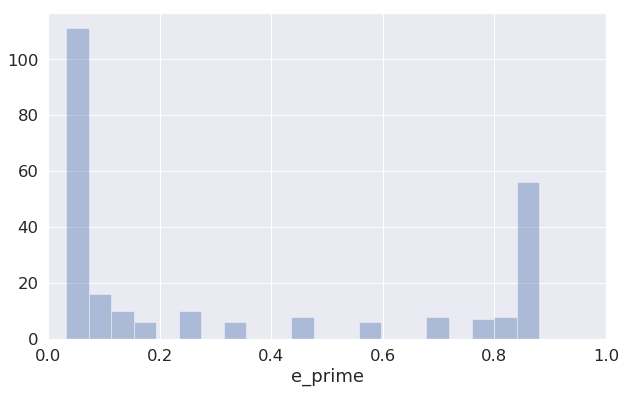

In [8]:
#plot e_prime distribution
df = df_results
idx = (df.outcome == 'self-confining')
dfs = df[idx]
bins = 21
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
yp = dfs.e_prime
p = sns.distplot(yp, ax=ax, bins=bins, kde=False)
p = ax.set_xlim(0.0, 1.0)

In [9]:
#spot-check the unconfined sims
df = df_results
idx = (df.outcome == 'unconfined')
print 'number of unconfined sims = ', idx.sum()
q_mean = df[idx].q.mean()
q_std = df[idx].q.std()
print 'q_mean = ', q_mean
print 'q_std = ', q_std
cols = ['sim_id', 'expected_timestep', 'current_timestep', 
    'timesteps_per_output', 'dynamical_timescale', 'viscous_timescale', 'q', 'delta_q_over_q', 'outcome']
df[idx][cols]

number of unconfined sims =  0
q_mean =  nan
q_std =  nan


,sim_id,expected_timestep,current_timestep,timesteps_per_output,dynamical_timescale,viscous_timescale,q,delta_q_over_q,outcome


In [10]:
#spot-check the dynamical_timescale=Null sims...these all have crossed streamlines
df = df_results
idx = ~(df.dynamical_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx].outcome.value_counts()

crossed streamlines    54
Name: outcome, dtype: int64

In [11]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'total_ring_mass', 'radial_width', 'shear_viscosity', 
    'e_prime', 'q', 'delta_q_over_q', 'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

('nominal sim_id = ', 442)


,sim_id,expected_timestep,current_timestep,total_ring_mass,radial_width,shear_viscosity,e_prime,q,delta_q_over_q,dynamical_timescale,viscous_timescale,outcome
442,442,1700000,1700000,1.000000e-10,0.0001,1.000000e-13,0.879683,0.879982,0.000264,85000.0,8386.687069,self-confining


In [12]:
#store outcomes as parquet file
df = df_results
file = 'df_results.parquet'
df.to_parquet(file, engine='pyarrow')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'timesteps_per_output',
    'dynamical_timescale', 'viscous_timescale', 'q', 'e_prime', 'outcome']
df[cols].sample(10)

,sim_id,expected_timestep,current_timestep,streamline_crossing_timestep,timesteps_per_output,dynamical_timescale,viscous_timescale,q,e_prime,outcome
373,373,12240000,4896000,4403472.0,12240,587520.0,4.524769e+04,NaN,NaN,crossed streamlines
127,127,1436000,71800,15977.0,1436,5026.0,7.181460e+04,NaN,NaN,crossed streamlines
411,411,136000,136000,NaN,136,6800.0,7.185079e+02,0.870095,0.241885,self-confining
205,205,142000,142000,NaN,142,7171.0,2.083502e+01,0.867052,0.033250,self-confining
409,409,146000,146000,NaN,146,7373.0,4.524769e+01,0.870091,0.241915,self-confining
534,534,1700000,850000,827949.0,1700,NaN,8.874532e+04,NaN,NaN,crossed streamlines
237,237,131000,131000,NaN,131,6550.0,9.672449e+02,0.868971,0.177795,self-confining
55,55,1700000,85000,15250.0,1700,5100.0,3.333335e+06,NaN,NaN,crossed streamlines
36,36,142000,120700,118105.0,142,7100.0,5.208387e+01,NaN,NaN,crossed streamlines
83,83,309000,185400,171426.0,309,4944.0,1.547197e+04,NaN,NaN,crossed streamlines


In [13]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.800    64
0.130    61
0.037    65
0.000    62
Name: e_prime_bracket, dtype: int64

In [14]:
df_results.outcome.value_counts()

crossed streamlines    320
self-confining         252
Name: outcome, dtype: int64

file =  figs/sim_grid_da_0p000025.pdf     radial_width =  2.5e-05
file =  figs/sim_grid_da_0p00005.pdf     radial_width =  5e-05
file =  figs/sim_grid_da_0p0001.pdf     radial_width =  0.0001
file =  figs/sim_grid_da_0p0002.pdf     radial_width =  0.0002


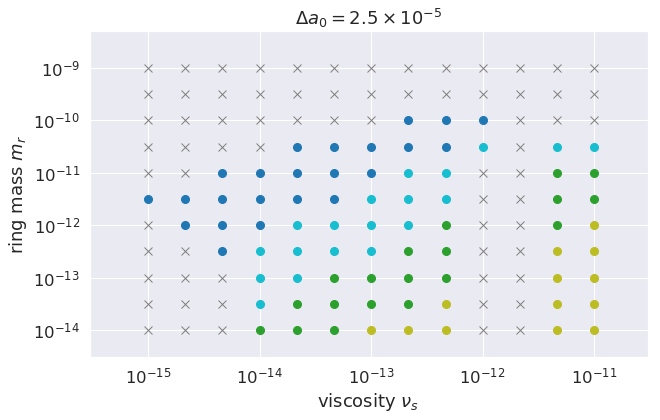

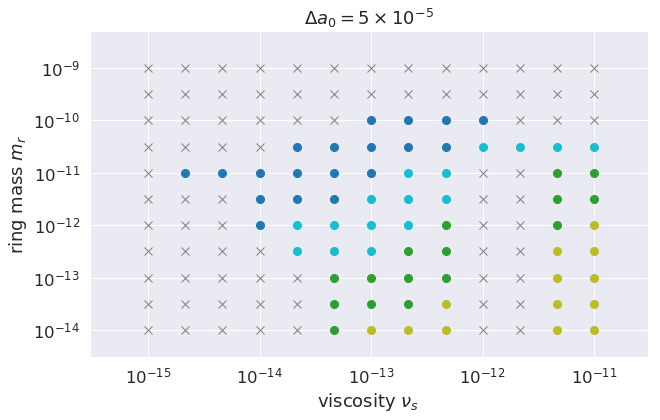

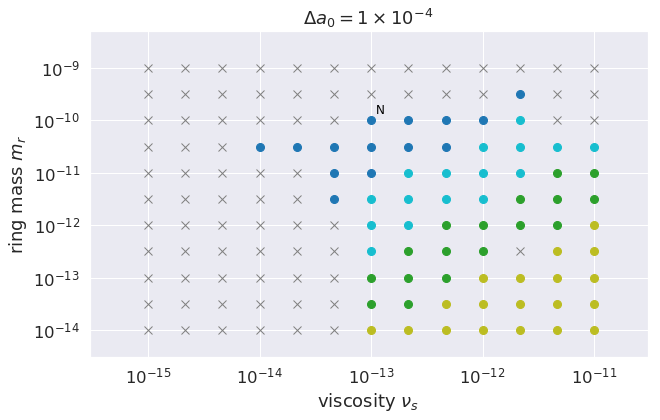

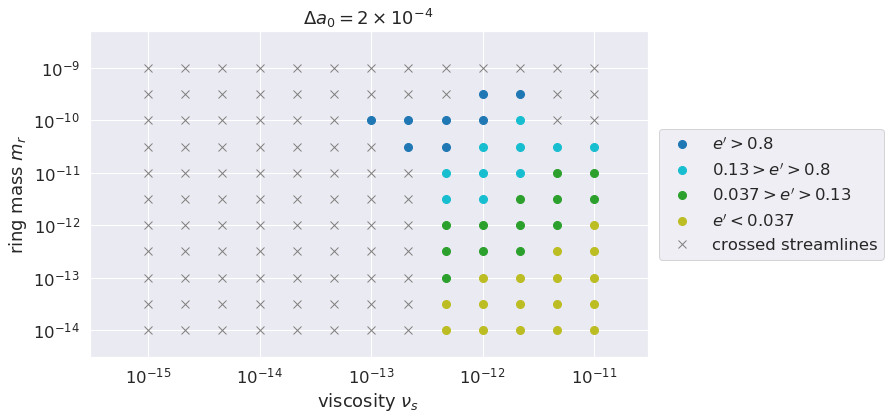

In [15]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.8, r"$e'>0.8$", color_seq[0]),
                    (0.13, r"$0.13>e'>0.8$", color_seq[9]),
                    (0.037, r"$0.037>e'>0.13$", color_seq[2]),
                    (0.0, r"$e' <0.037$", color_seq[8])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #diamond for simulation complete sims
    idx = (dfs.outcome == 'unconfined')
    dfss = dfs[idx]
    if (len(dfss) > 0):
        xp = dfss.shear_viscosity
        yp = dfss.total_ring_mass
        color = color_seq[3]
        p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unconfined')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (1.1*xp, 1.3*yp)
        color = color_seq[3]
        p = ax.annotate('N', xy, fontsize=12, color='black')
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    if (radial_width == 2.5e-5):
        title = r'$\Delta a_0 = 2.5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p000025.pdf'
    if (radial_width == 5.0e-5):
        title = r'$\Delta a_0 = 5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p00005.pdf'
    if (radial_width == 1.0e-4):
        title = r'$\Delta a_0 = 1\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0001.pdf'
    if (radial_width == 2.0e-4):
        title = r'$\Delta a_0 = 2\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0002.pdf'
    p = ax.set_title(title)
    p = ax.set_xlim(3.0e-16, 3.0e-11)
    p = ax.set_ylim(3.0e-15, 5.0e-9)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    print 'file = ', file, '    radial_width = ', radial_width
    plt.savefig(file, bbox_inches='tight')

In [16]:
#conda install scikit-learn
#conda install pyarrow

number of e_prime_bracket=0.86 sims =  64
number of sims plotted =  5


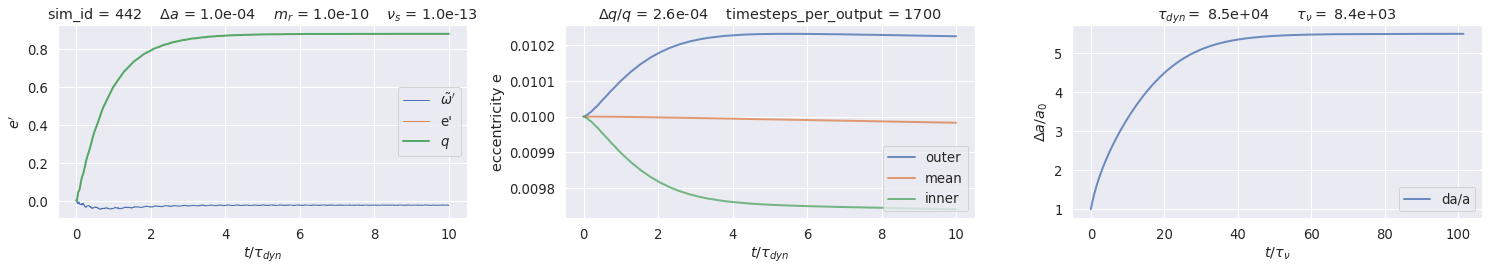

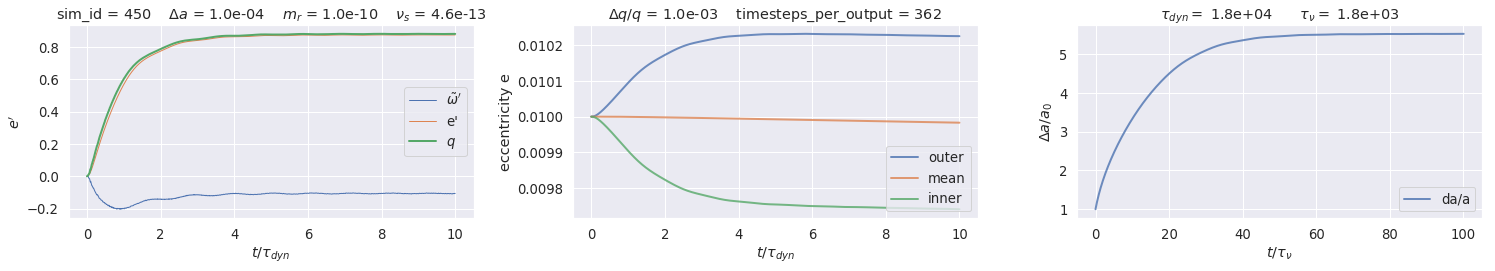

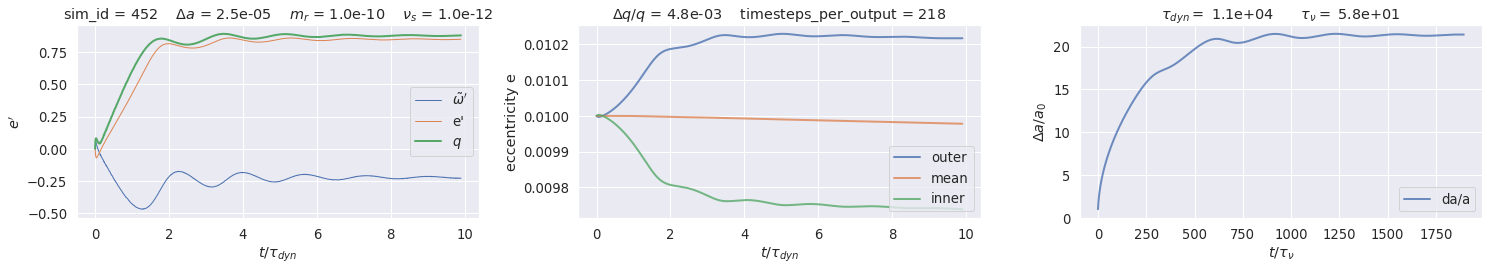

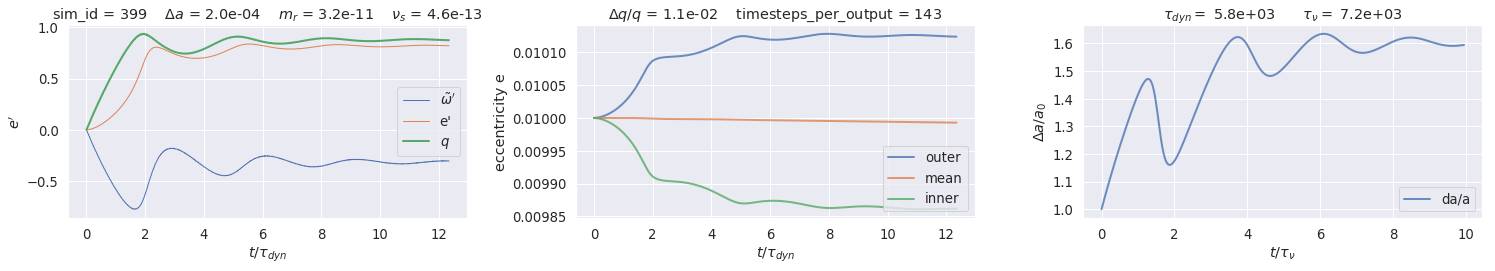

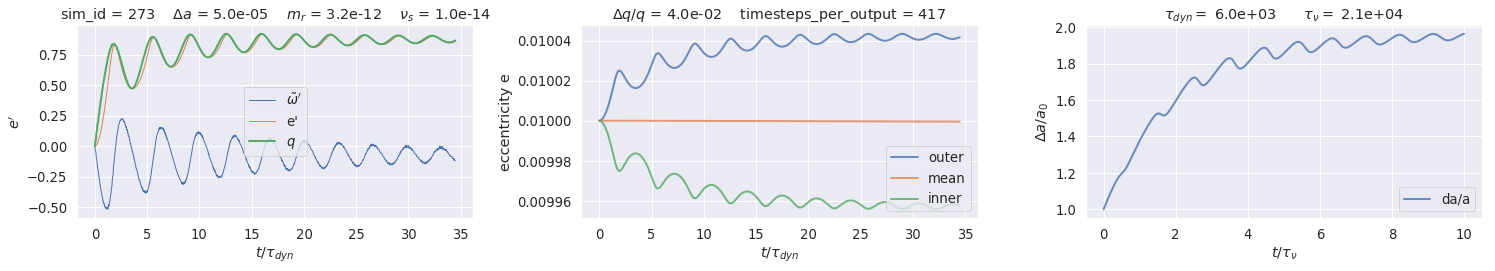

In [17]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.8
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.86 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.4 sims =  61
number of sims plotted =  5


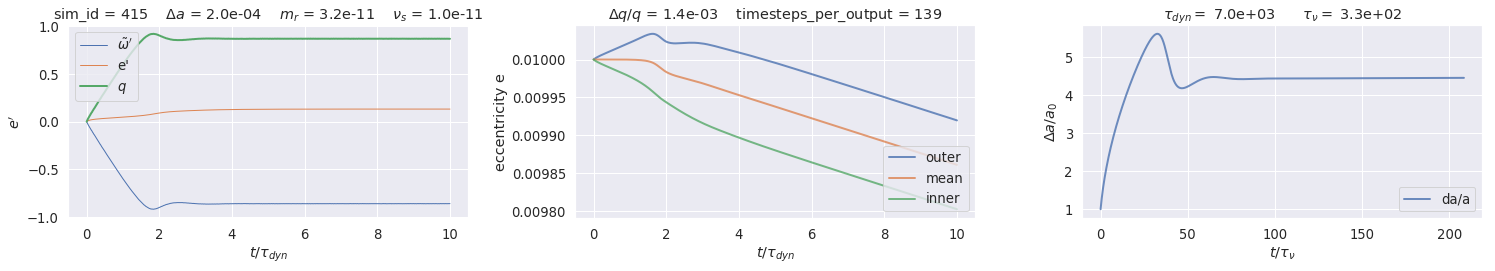

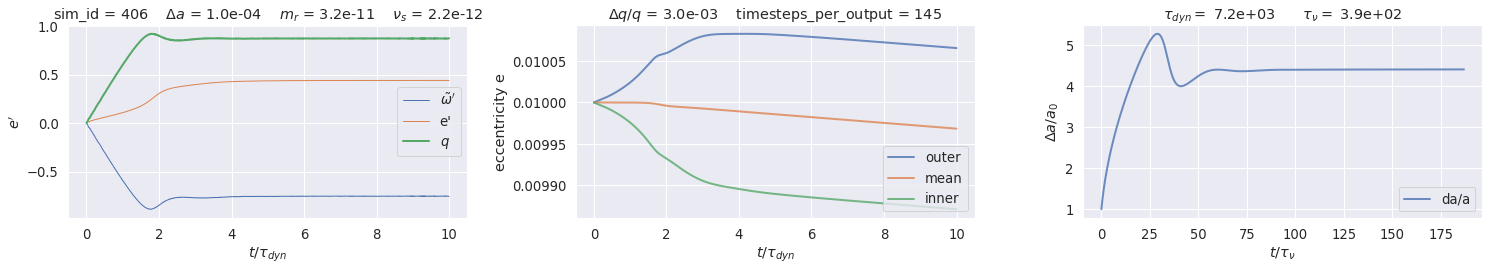

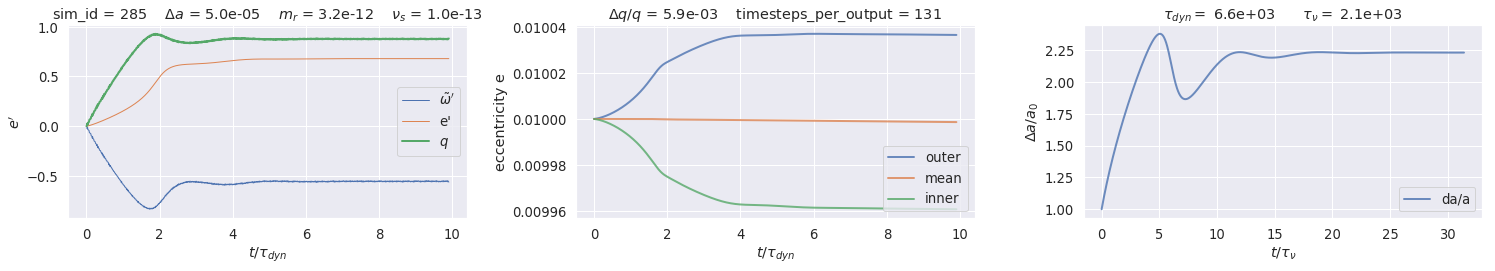

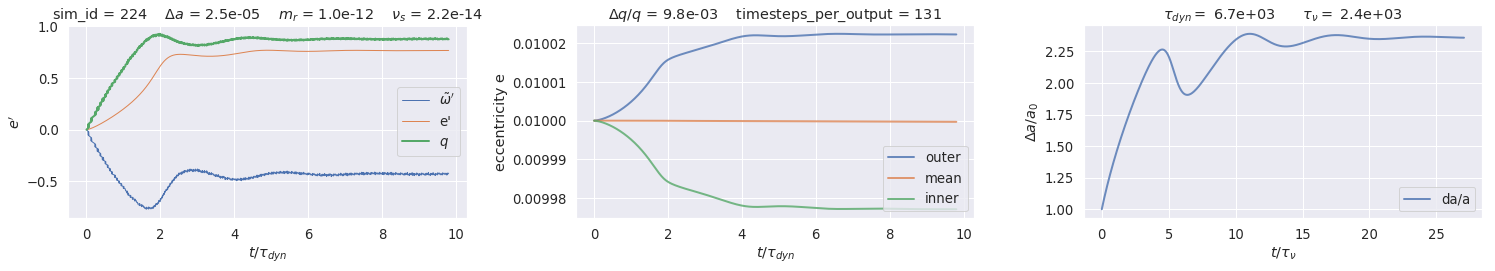

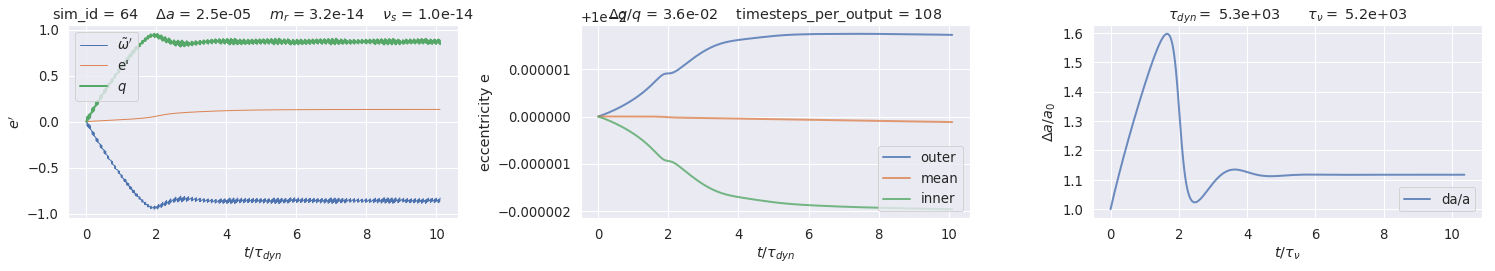

In [18]:
#generate summary plots for sample of e_prime_bracket=0.13 (ie 0.13<e'<0.8) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.13
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.4 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.06 sims =  65
number of sims plotted =  5


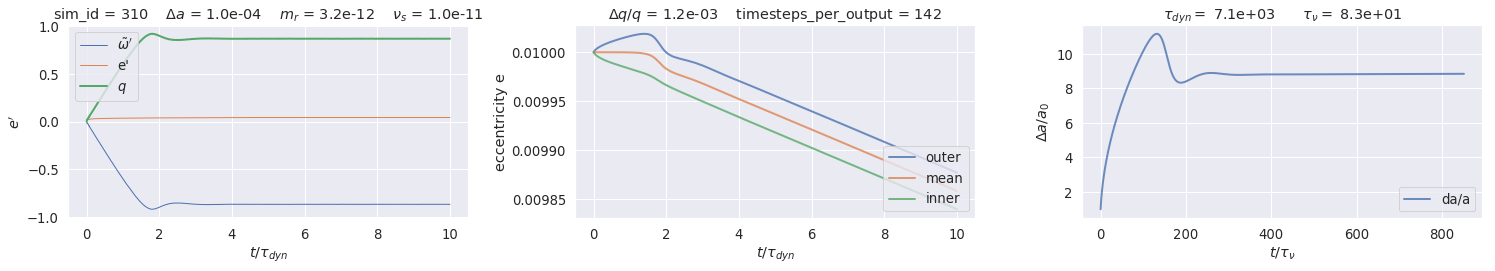

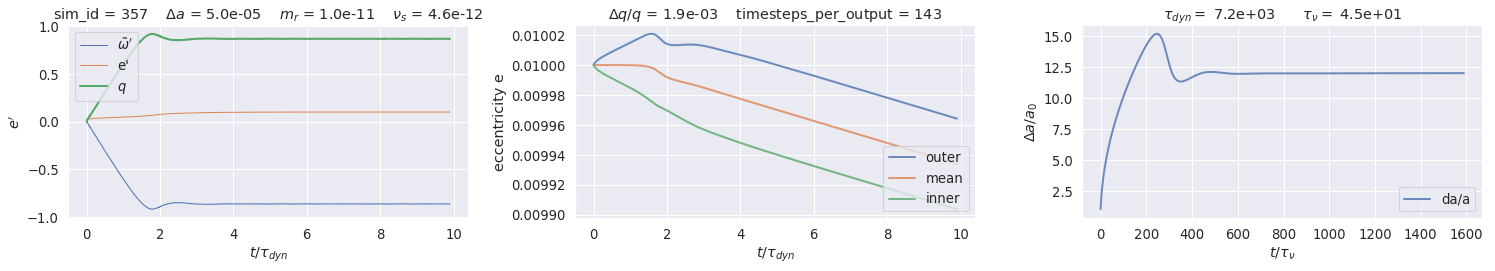

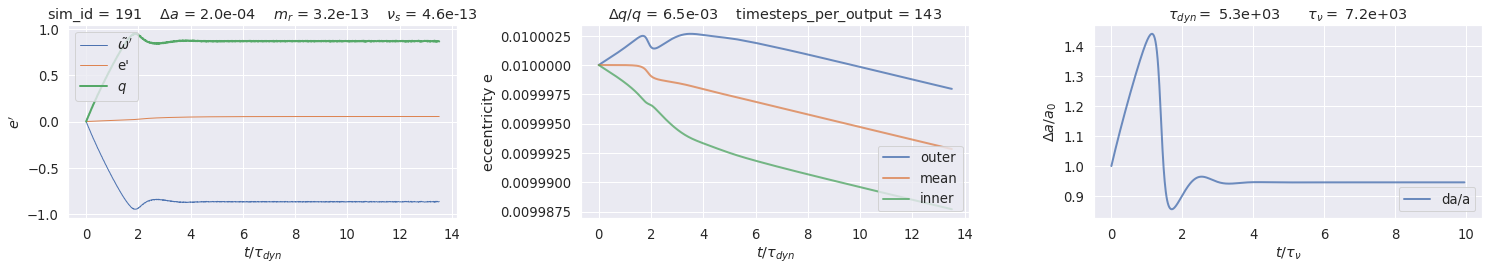

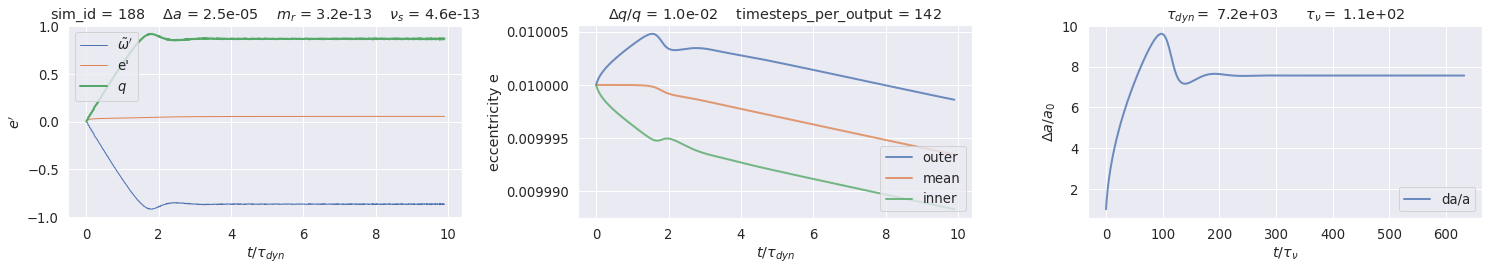

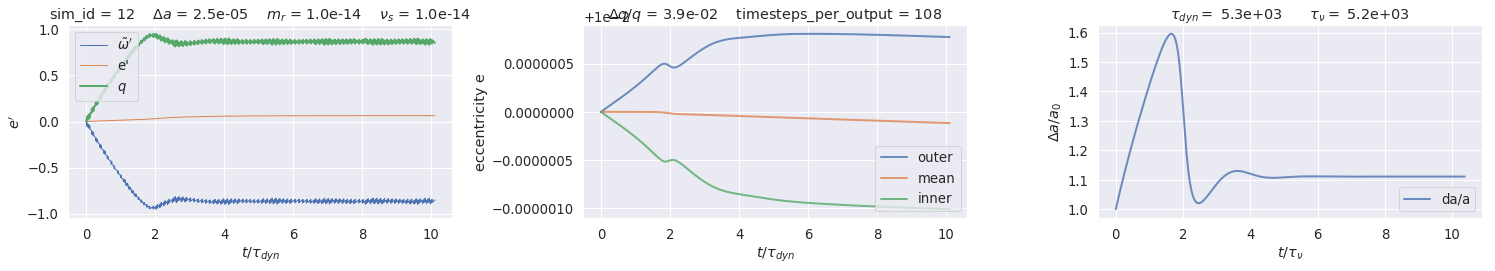

In [19]:
#generate summary plots for sample of e_prime_bracket=0.037 (ie 0.037<e'<0.13) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.037
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.06 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  62
number of sims plotted =  5


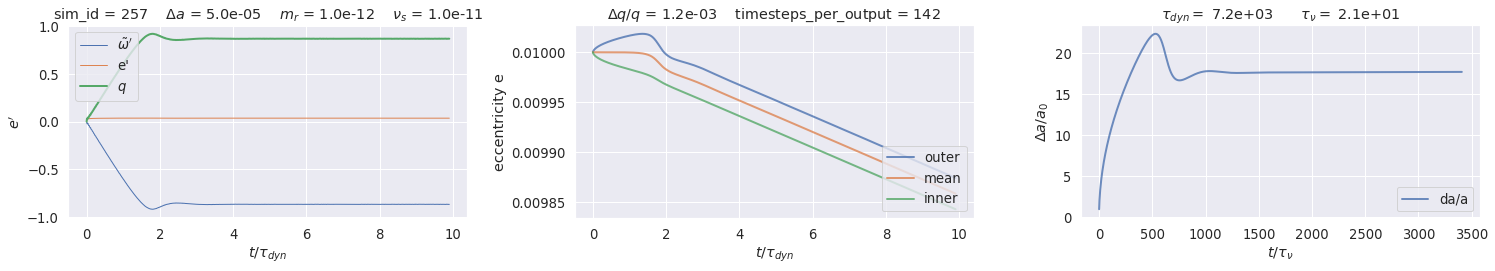

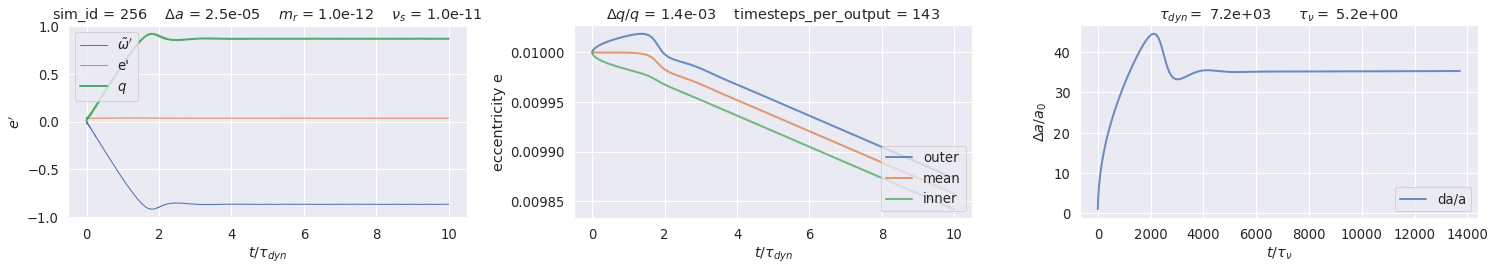

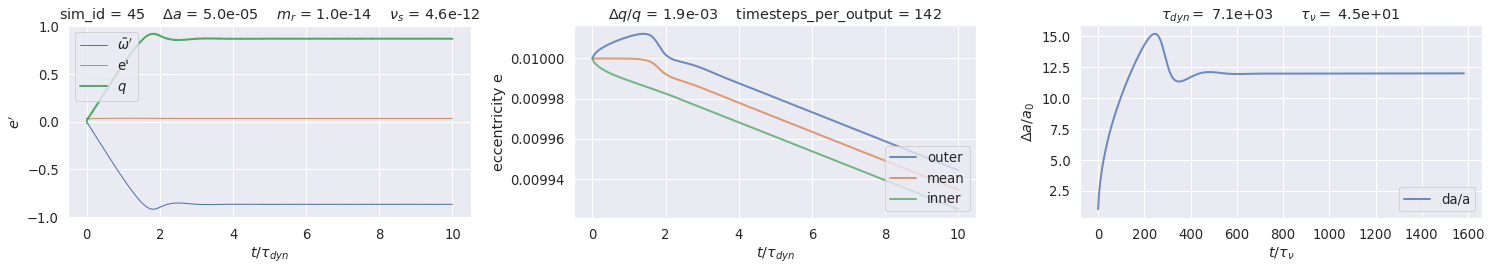

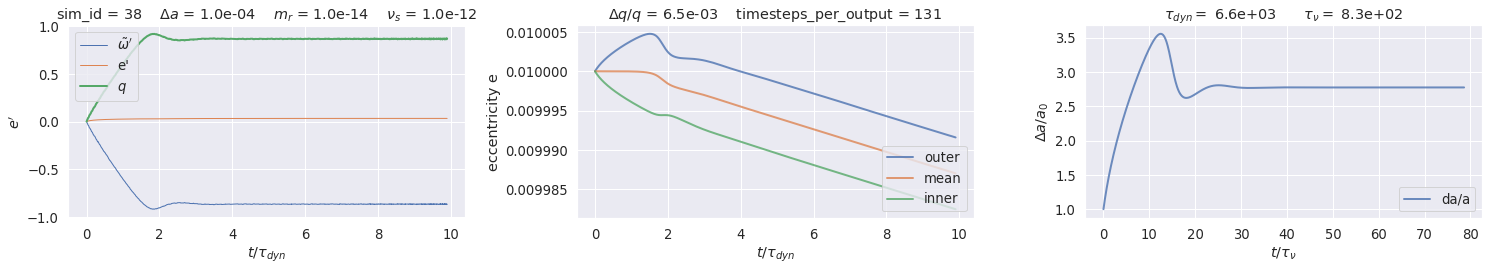

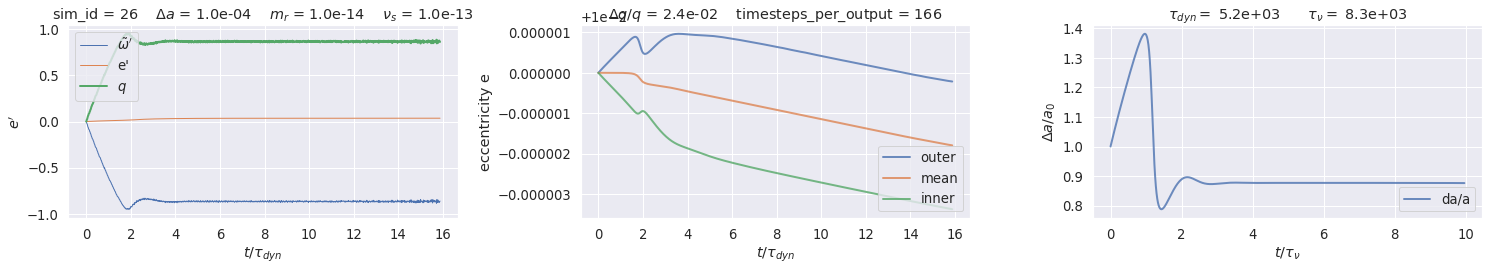

In [20]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.037) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

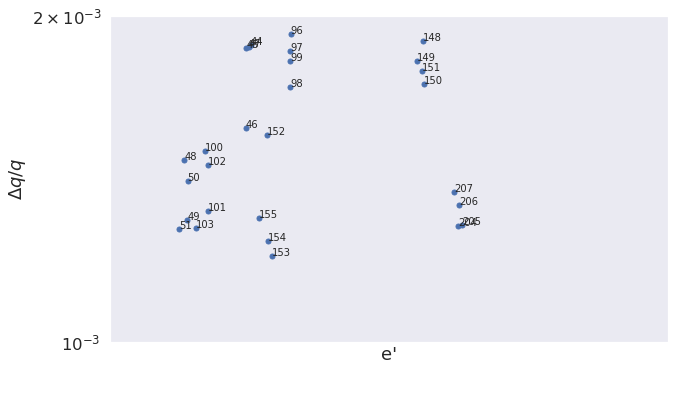

In [21]:
#select low delta_q_over_q sims having a variety of e_prime 
df = df_results
delta_q_over_q_max = 0.0029
sim_ids = [338, 355, 242, 303, 247, 307, 251, 309, 255, 199, 258, 203, 147, 150, 48]
idx = (df.outcome == 'self-confining')
df = df[idx]
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(figsize=(10, 6))
xp = df.e_prime
yp = df.delta_q_over_q
p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=5)
p = ax.axhline(delta_q_over_q_max, linestyle='dashed', color=color_seq[1])
for idx, row in df.iterrows():
    xy = (row.e_prime, row.delta_q_over_q)
    s = str(int(row.sim_id))
    p = ax.annotate(s, xy=xy, fontsize=10)
p = ax.set_ylabel(r'$\Delta q/q$')
p = ax.set_xlabel("e'")
p = ax.set_xscale('log')
p = ax.set_yscale('log')
#p = ax.set_xlim(0.03, 1.0)
#p = ax.set_ylim(0.0005, 0.005)
p = ax.set_xlim(0.032, 0.034)
p = ax.set_ylim(0.001, 0.002)
sim_ids = [51, 49, 101, 154, 205, 147, 98, 150, 205, 201, 259, 199, 255, 308, 251, 307, 362, 
    303, 359, 415, 355, 411, 351, 407, 346, 403, 459, 442, 324]

In [22]:
#df = df_results
#idx = (df.outcome == 'self-confining')
#df = df[idx]
#idx = (df.shear_viscosity < 2.0e-15)
#df = df[idx]
#idx = (df.e_prime_bracket ==  0.8)
#df = df[idx]
#idx = (df.delta_q_over_q < 0.01)
#df = df.sort_values('delta_q_over_q')
#df

In [23]:
#ringlet eccentricity gradients
ringlets = {'Maxwell':0.663, 'Titan':0.425, 'Laplace':0.039, 'Huygens':0.008}

number of selected sims =  28
radial_width min, max =  2.5e-05 0.0002
total_ring_mass min, max =  9.999999999999987e-15 9.999999999999996e-11
shear_viscosity min, max =  9.999999999999987e-15 9.999999999999985e-12


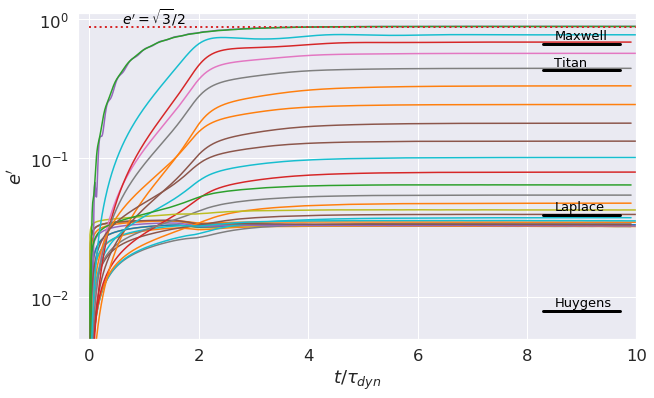

In [24]:
#plot e' vs time for selected sim_ids
df = df_results
idx = (df.sim_id.isin(sim_ids))
df = df[idx]
print 'number of selected sims = ', len(df)
print 'radial_width min, max = ', df.radial_width.min(), df.radial_width.max()
print 'total_ring_mass min, max = ', df.total_ring_mass.min(), df.total_ring_mass.max()
print 'shear_viscosity min, max = ', df.shear_viscosity.min(), df.shear_viscosity.max()
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
for idx, row in df.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    xp = times_dynamical
    yp = e_prime
    label = str(row.sim_id)
    color = color_seq[idx%len(color_seq)]
    p = ax.plot(xp, yp, linestyle='-', linewidth=1.5, color=color, label=label)
    #xy=(10.0, 0.95*row.e_prime)
    #s = str(row.sim_id)
    #p = ax.annotate(s, xy=xy, fontsize=12, color=color)
for ringlet, e_prime in ringlets.iteritems():
    xp = np.array([8.3, 9.7])
    yp = xp*0 + e_prime
    color = 'black'
    p = ax.plot(xp, yp, linestyle='-', linewidth=3, color=color)
    xy = (8.5, 1.08*e_prime)
    p = ax.annotate(ringlet, xy, color=color, fontsize=13)
xp = np.array([0, 10])
yp = xp*0 + np.sqrt(3.0)/2.0
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='dotted', linewidth=2, color=color)
p = ax.annotate(r"$e'=\sqrt{3}/2$", (0.60, 0.92), color='black', fontsize=14)
p = ax.set_ylabel(r"$e'$")
p = ax.set_xlabel(r'$t/\tau_{dyn}$')
p = ax.set_yscale('log')
p = ax.set_ylim(0.005, 1.1)
p = ax.set_xlim(-0.2, 10.0)
file = 'figs/e_prime_selected.pdf'
plt.savefig(file, bbox_inches='tight')

In [25]:
#generate summary plots for all unconfined sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'unconfined')
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
N_unconfined = len(dfs)
print 'number of unconfined sims = ', N_unconfined
if (N_unconfined > 0):
    print 'number of sims plotted = ', len(dfs)
    for idx, row in dfs.iterrows():
        #read simulation input and revised output
        execfile('inputs.py')
        path = row.path
        r, t, vr, vt, times, monitor = restore_output(path)
        dynamical_timescale = row.dynamical_timescale
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        da_init = da[0]
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #create grid of plots
        sns.set(font_scale=1.2, font='DejaVu Sans')
        fig, axs = plt.subplots(1, 3, figsize=(21, 4))
        #plot e_prime wt_prime and q versus time
        ax = axs[0]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        sim_id = row.sim_id
        radial_width = row.radial_width
        total_ring_mass = row.total_ring_mass
        shear_viscosity = row.shear_viscosity
        title = 'sim_id = ' + str(sim_id)
        title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
        title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
        title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlabel(r'$t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.legend()
        p = plt.tight_layout()
        #plot streamline's e-evolution
        ax = axs[1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'$t/\tau_{dyn}$')
        delta_q_over_q = row.delta_q_over_q
        timesteps_per_output = row.timesteps_per_output
        title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
        title += r'    timesteps_per_output = ' + str(timesteps_per_output)
        p = ax.set_title(title)
        p = ax.legend(loc='lower right')
        #plot da vs times
        ax = axs[2]
        viscous_timescale = row.viscous_timescale
        times_viscous = times/viscous_timescale
        x = times_viscous
        da0 = da[0]
        y = da/da0
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
        p = ax.set_ylabel(r'$\Delta a/a_0$')
        p = ax.set_xlabel(r'$t/\tau_{\nu}$')
        title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
        title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
        p = ax.set_title(title)
        p = ax.legend(loc='lower right')
        p = plt.tight_layout()

number of unconfined sims =  0


number of sims plotted =  10


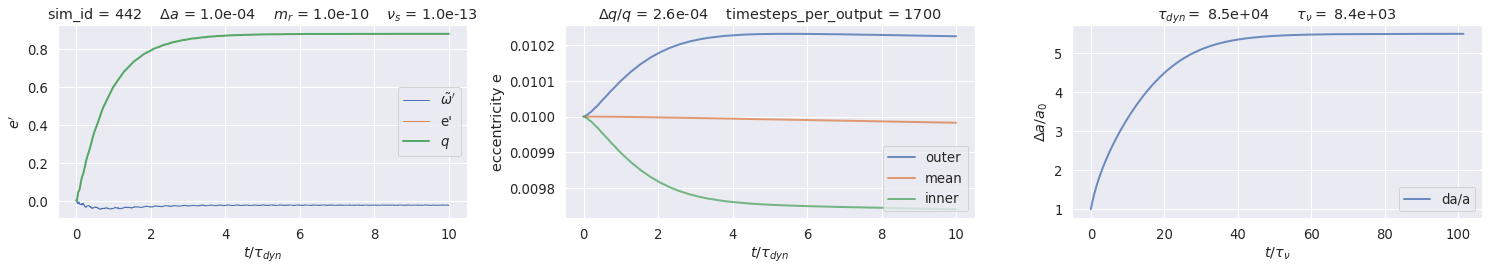

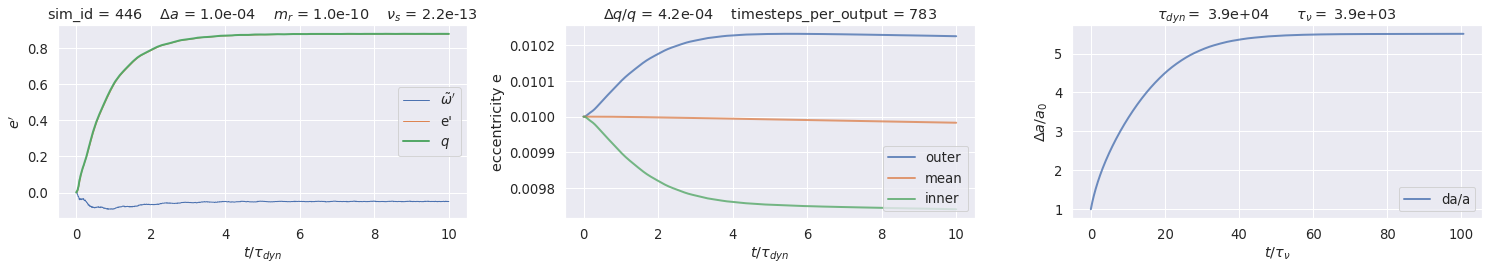

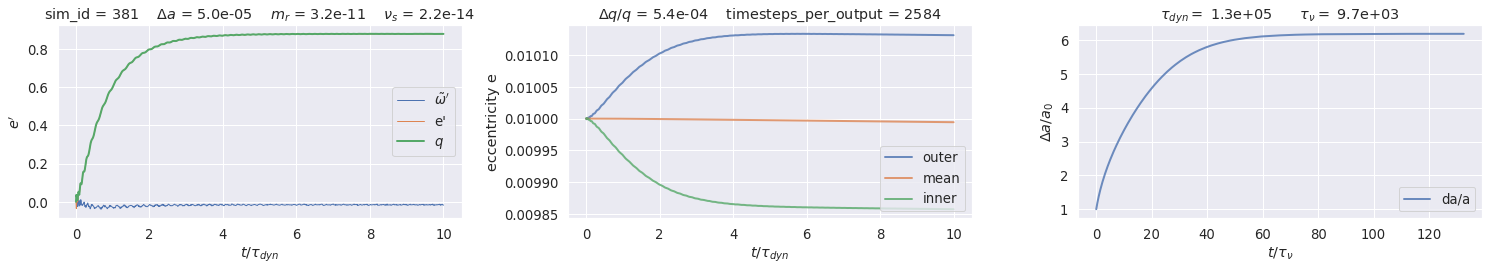

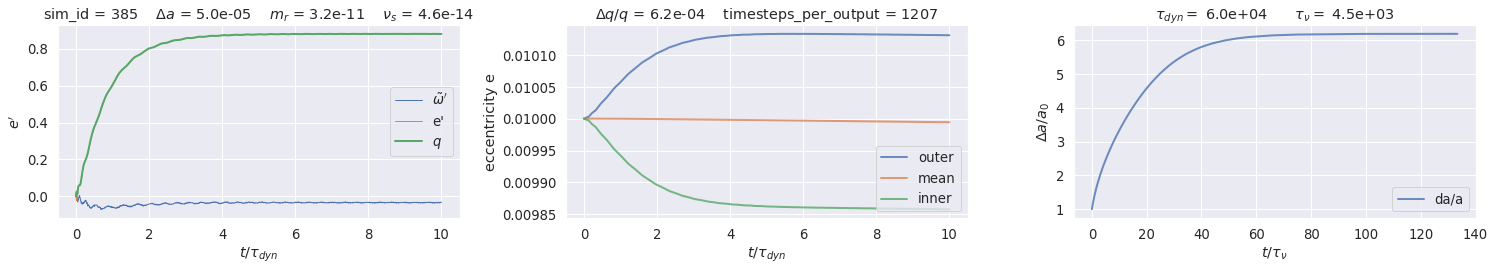

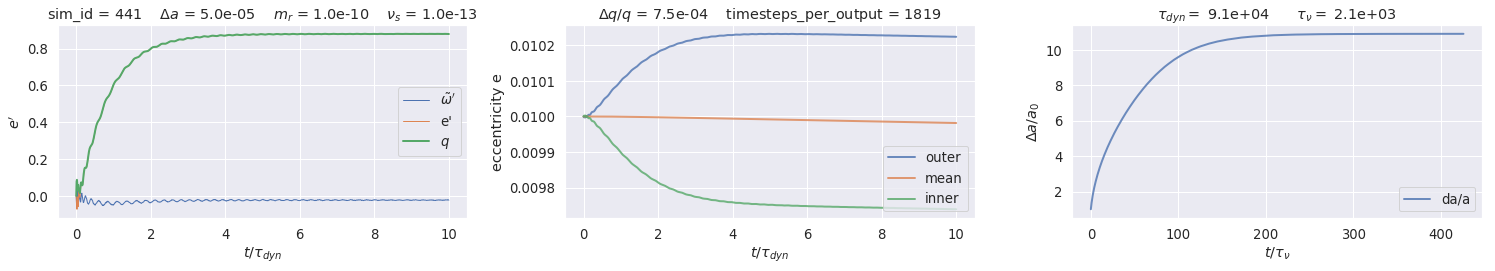

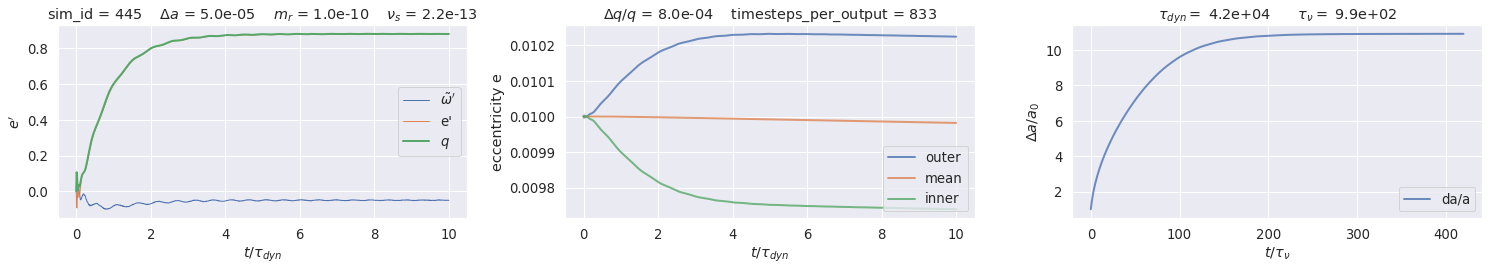

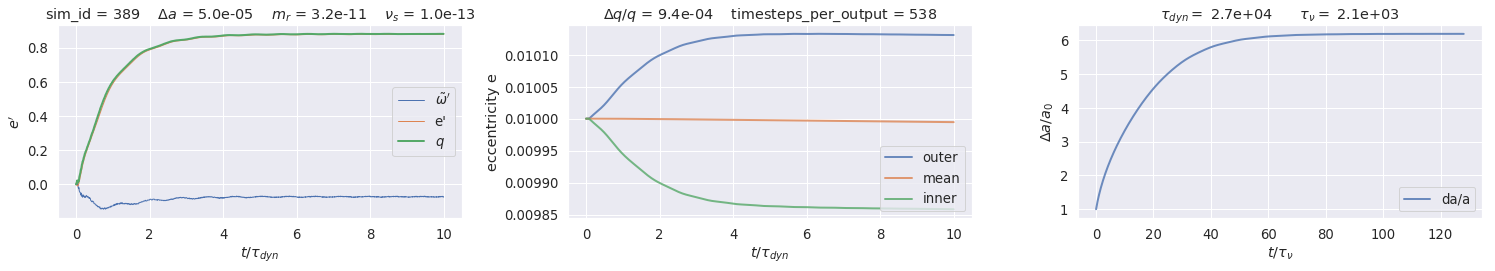

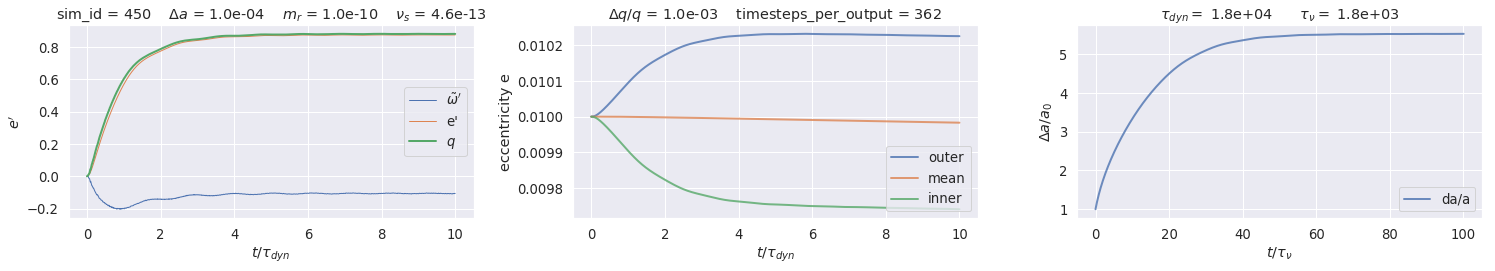

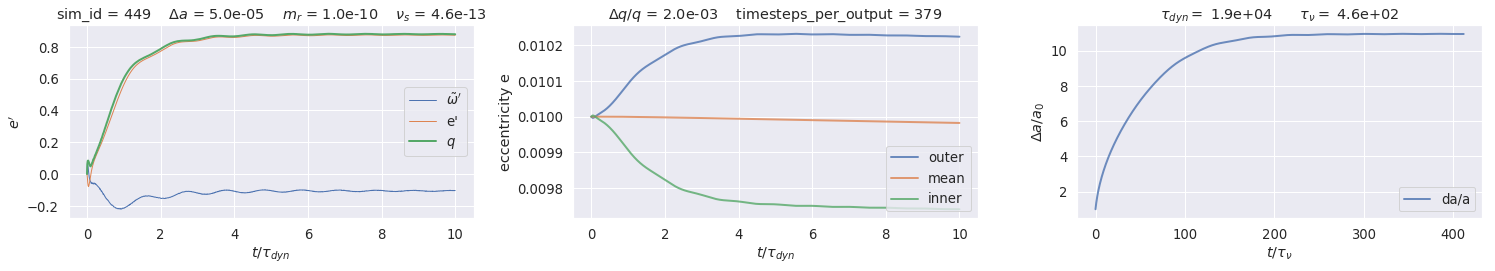

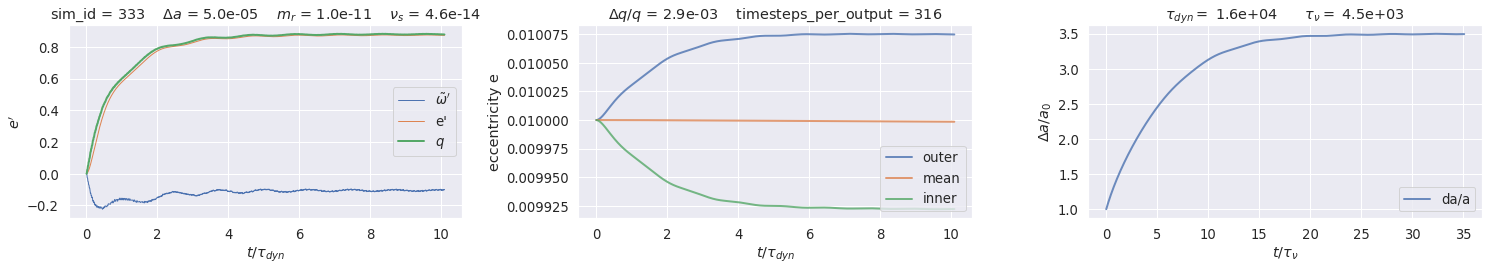

In [26]:
#find most nominal sim
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'self-confining')
dfs = df[idx].copy()
idx = (dfs.radial_width > 3.0e-5) & (dfs.radial_width < 1.5e-4) & (dfs.e_prime_bracket > 0.7) \
    & (dfs.delta_q_over_q < 0.003)
dfss = dfs[idx]
dfss = dfss.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()


In [27]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min

time_exec_min =  1.31033178568
